In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split


In [2]:
# Simple Kaggle download using kagglehub (no kaggle.json needed for public datasets)

import sys, shutil
from pathlib import Path

try:
    import kagglehub  # type: ignore
except ModuleNotFoundError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kagglehub"])
    import kagglehub  # type: ignore


KAGGLE_DATASET = "rohanrao/formula-1-world-championship-1950-2020"

def download_dataset(dataset=KAGGLE_DATASET, target_dir="data"):
    cache_path = Path(kagglehub.dataset_download(dataset))  # returns a local cache dir
    dest = Path(target_dir)
    dest.mkdir(parents=True, exist_ok=True)

    # Copy everything from the cache to your target dir
    for item in cache_path.iterdir():
        dst = dest / item.name
        if item.is_dir():
            shutil.copytree(item, dst, dirs_exist_ok=True)
        else:
            shutil.copy2(item, dst)

    print("✅ Dataset ready in:", dest.resolve())

# Run once
download_dataset()


100%|██████████| 6.28M/6.28M [00:00<00:00, 34.3MB/s]

Extracting files...


✅ Dataset ready in: /content/data


In [3]:
#Step 3

import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("data")
# Core tables
races = pd.read_csv(DATA_DIR / "races.csv")
results = pd.read_csv(DATA_DIR / "results.csv")
circuits = pd.read_csv(DATA_DIR / "circuits.csv")
drivers = pd.read_csv(DATA_DIR / "drivers.csv")
constructors = pd.read_csv(DATA_DIR / "constructors.csv")
pit_stops = pd.read_csv(DATA_DIR / "pit_stops.csv") if (DATA_DIR / "pit_stops.csv").exists() else pd.DataFrame()
status = pd.read_csv(DATA_DIR / "status.csv")

# Filter to 2010+ (better pit data consistency)
races_2010 = races[races["year"] >= 2010].copy()

# Join keys
df = results.merge(races_2010[["raceId","year","round","circuitId","name","date"]], on="raceId", how="inner")             .merge(circuits[["circuitId","name","country","location","lat","lng","alt"]].rename(columns={"name":"circuitName"}),
                   on="circuitId", how="left")             .merge(constructors[["constructorId","name"]].rename(columns={"name":"constructorName"}),
                   on="constructorId", how="left")             .merge(drivers[["driverId","driverRef","surname","forename","nationality"]], on="driverId", how="left")

# Attach pit stops (optional; not all races have pit data)
if not pit_stops.empty:
    pit_agg = pit_stops.groupby(["raceId","driverId"]).agg(
        pit_count=("stop","count"),
        pit_total_duration=("milliseconds","sum"),
        pit_avg_duration=("milliseconds","mean"),
        first_pit_lap=("lap","min"),
        last_pit_lap=("lap","max"),
    ).reset_index()
else:
    pit_agg = pd.DataFrame(columns=["raceId","driverId","pit_count","pit_total_duration",
                                    "pit_avg_duration","first_pit_lap","last_pit_lap"])

df = df.merge(pit_agg, on=["raceId","driverId"], how="left")

# Basic cleaning / target definitions
df["finish_pos"] = df["positionOrder"].astype(float)

# Remove entries with missing grid
df = df[df["grid"].notna()].copy()

# DNF flag
status_map = dict(status[["statusId","status"]].values)
df["statusText"] = df["statusId"].map(status_map)
df["dnf"] = ~df["statusText"].fillna("").str.lower().eq("finished")

# Engineered features
df["delta_grid_finish"] = df["finish_pos"] - df["grid"]
df["is_home_constructor"] = (df["constructorId"].notna()).astype(int)  # simple placeholder

for col in ["pit_count","pit_total_duration","pit_avg_duration","first_pit_lap","last_pit_lap"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Overtaking difficulty per circuit: avg positions gained (negative delta = gained)
circuit_overtake = df.groupby("circuitId")["delta_grid_finish"].mean().rename("circuit_overtake_difficulty")
df = df.merge(circuit_overtake, on="circuitId", how="left")

cols = [
    "raceId","driverId","constructorId","year","round","circuitId","circuitName","country",
    "grid","finish_pos","delta_grid_finish","dnf",
    "pit_count","pit_total_duration","pit_avg_duration","first_pit_lap","last_pit_lap",
    "circuit_overtake_difficulty"
]
model_df = df[cols].dropna(subset=["finish_pos"]).copy()

print(model_df.head())
print(model_df.shape)


   raceId  driverId  constructorId  year  round  circuitId  \
0     337         4              6  2010      1          3   
1     337        13              6  2010      1          3   
2     337         1              1  2010      1          3   
3     337        20              9  2010      1          3   
4     337         3            131  2010      1          3   

                     circuitName  country  grid  finish_pos  \
0  Bahrain International Circuit  Bahrain     3         1.0   
1  Bahrain International Circuit  Bahrain     2         2.0   
2  Bahrain International Circuit  Bahrain     4         3.0   
3  Bahrain International Circuit  Bahrain     1         4.0   
4  Bahrain International Circuit  Bahrain     5         5.0   

   delta_grid_finish    dnf  pit_count  pit_total_duration  pit_avg_duration  \
0               -2.0  False        0.0                 0.0               0.0   
1                0.0  False        0.0                 0.0               0.0   
2       

In [4]:

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np

num_features = ["grid","pit_count","pit_total_duration","pit_avg_duration",
                "first_pit_lap","last_pit_lap","circuit_overtake_difficulty","round"]
cat_features = ["circuitId","country"]

X = model_df[num_features + cat_features]
y = model_df["finish_pos"]
groups = model_df["year"]

preprocess = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
])

reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1
)

pipe = Pipeline([("prep", preprocess), ("model", reg)])

gkf = GroupKFold(n_splits=5)
maes = []
for fold, (tr, va) in enumerate(gkf.split(X, y, groups=groups), 1):
    pipe.fit(X.iloc[tr], y.iloc[tr])
    preds = pipe.predict(X.iloc[va])
    mae = mean_absolute_error(y.iloc[va], preds)
    maes.append(mae)
    print(f"Fold {fold} MAE: {mae:.3f}")

print(f"Average MAE across folds: {np.mean(maes):.3f} ± {np.std(maes):.3f}")


Fold 1 MAE: 3.449
Fold 2 MAE: 3.176
Fold 3 MAE: 3.488
Fold 4 MAE: 4.951
Fold 5 MAE: 3.631
Average MAE across folds: 3.739 ± 0.624


In [5]:

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

clf_df = model_df.copy()
clf_df["top3"] = (clf_df["finish_pos"] <= 3).astype(int)

Xc = clf_df[num_features + cat_features]
yc = clf_df["top3"]

clf = Pipeline([
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

accs, f1s, aucs = [], [], []
for fold, (tr, va) in enumerate(gkf.split(Xc, yc, groups=clf_df["year"]), 1):
    clf.fit(Xc.iloc[tr], yc.iloc[tr])
    prob = clf.predict_proba(Xc.iloc[va])[:,1]
    pred = (prob >= 0.5).astype(int)
    accs.append(accuracy_score(yc.iloc[va], pred))
    f1s.append(f1_score(yc.iloc[va], pred))
    try:
        aucs.append(roc_auc_score(yc.iloc[va], prob))
    except:
        aucs.append(np.nan)
    print(f"Fold {fold} — Acc: {accs[-1]:.3f}, F1: {f1s[-1]:.3f}, ROC-AUC: {aucs[-1]:.3f}")

print(f"Mean Acc: {np.mean(accs):.3f}, Mean F1: {np.mean(f1s):.3f}, Mean AUC: {np.nanmean(aucs):.3f}")


Fold 1 — Acc: 0.801, F1: 0.546, ROC-AUC: 0.907
Fold 2 — Acc: 0.792, F1: 0.575, ROC-AUC: 0.909
Fold 3 — Acc: 0.798, F1: 0.563, ROC-AUC: 0.908
Fold 4 — Acc: 0.836, F1: 0.554, ROC-AUC: 0.890
Fold 5 — Acc: 0.820, F1: 0.585, ROC-AUC: 0.912
Mean Acc: 0.809, Mean F1: 0.565, Mean AUC: 0.905



## 🔍 Interpretation (SHAP on a sample) (Fixed
)

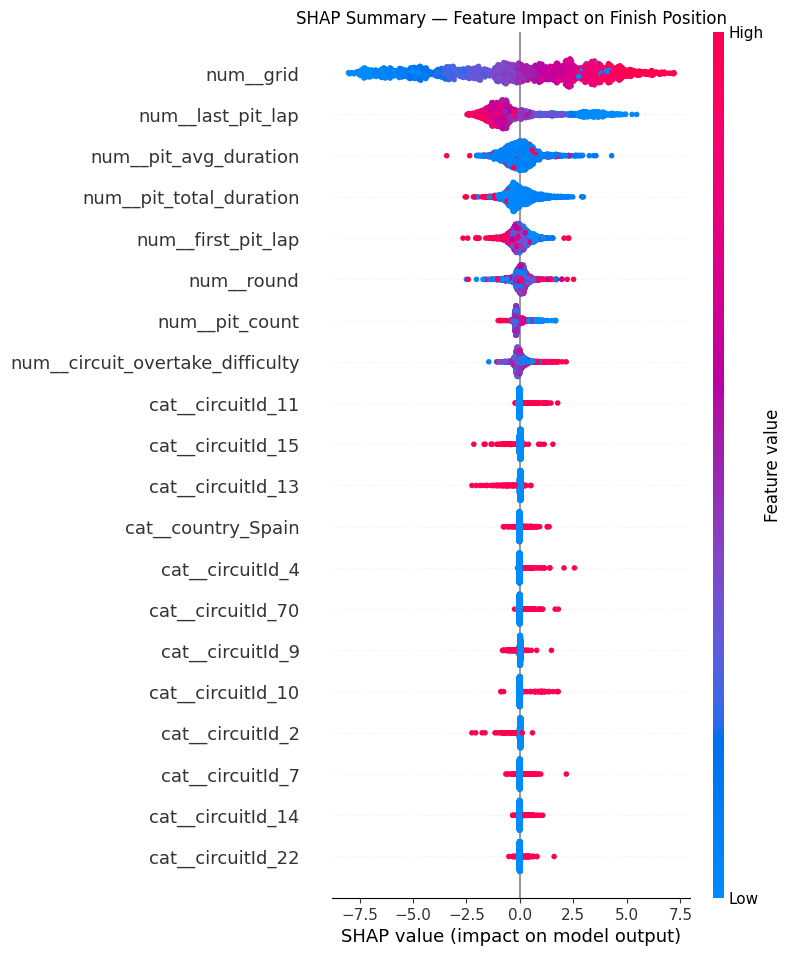

In [6]:
import re
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import sparse

pipe.fit(X, y)
model = pipe.named_steps["model"]
prep = pipe.named_steps["prep"]
X_trans = prep.transform(X)

sample_idx = np.random.choice(X_trans.shape[0], size=min(2000, X_trans.shape[0]), replace=False)
X_sample = X_trans[sample_idx]
X_plot = X_sample.toarray() if sparse.issparse(X_sample) else np.asarray(X_sample)

try:
    booster = model.get_booster()
except Exception:
    booster = None

shap_values = None

if booster is not None:
    try:
        dmat = xgb.DMatrix(X_sample)
        sv = booster.predict(dmat, pred_contribs=True)
        sv = np.asarray(sv)
        if sv.shape[1] == X_plot.shape[1] + 1:
            shap_values = sv[:, :-1]
    except Exception:
        pass

if shap_values is None and booster is not None:
    try:
        attrs = booster.attributes()
        bs = attrs.get("base_score")
        if isinstance(bs, str):
            m = re.search(r"-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?", bs)
            if m:
                booster.set_attr(base_score=str(float(m.group(0))))
        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(X_plot)
    except Exception:
        pass

if shap_values is None:
    try:
        explainer = shap.Explainer(model, X_plot)
        sv = explainer(X_plot)
        shap_values = getattr(sv, "values", sv)
    except Exception as e:
        raise e

try:
    feature_names = prep.get_feature_names_out()
except Exception:
    feature_names = None

shap.summary_plot(shap_values, X_plot, feature_names=feature_names, show=False)
plt.title("SHAP Summary — Feature Impact on Finish Position")
plt.show()


In [7]:

def scenario_to_features(circuit_name: str, grid: int, pit_laps: list, pit_ms: list, year_hint: int = 2021):
    import numpy as np
    import pandas as pd

    cand = circuits[circuits["name"].str.contains(circuit_name, case=False, na=False)]
    if cand.empty:
        raise ValueError(f"Circuit '{circuit_name}' not found. Check circuits.csv for names.")
    cid = int(cand.iloc[0]["circuitId"])
    country = cand.iloc[0]["country"] if "country" in cand.columns else "Unknown"

    pit_count = len(pit_laps)
    total_ms = int(np.sum(pit_ms)) if len(pit_ms) else 0
    avg_ms = int(np.mean(pit_ms)) if len(pit_ms) else 0
    first_lap = int(min(pit_laps)) if len(pit_laps) else 0
    last_lap = int(max(pit_laps)) if len(pit_laps) else 0

    cod = float(circuit_overtake.get(cid, circuit_overtake.mean()))

    row = pd.DataFrame([{
        "grid": grid,
        "pit_count": pit_count,
        "pit_total_duration": total_ms,
        "pit_avg_duration": avg_ms,
        "first_pit_lap": first_lap,
        "last_pit_lap": last_lap,
        "circuit_overtake_difficulty": cod,
        "round": 1,
        "circuitId": cid,
        "country": country
    }])

    return row

def predict_finish_and_top3(circuit_name, grid, pit_laps, pit_ms):
    X_row = scenario_to_features(circuit_name, grid, pit_laps, pit_ms)
    finish_pred = pipe.predict(X_row)[0]
    top3_prob = clf.predict_proba(X_row)[0,1]
    return finish_pred, top3_prob

# Example:
finish, p_top3 = predict_finish_and_top3("Monza", grid=3, pit_laps=[18, 37], pit_ms=[23000, 24000])
print(f"Predicted finish position: {finish:.1f}")
print(f"Probability of Top-3: {p_top3:.2%}")


Predicted finish position: 4.5
Probability of Top-3: 84.47%


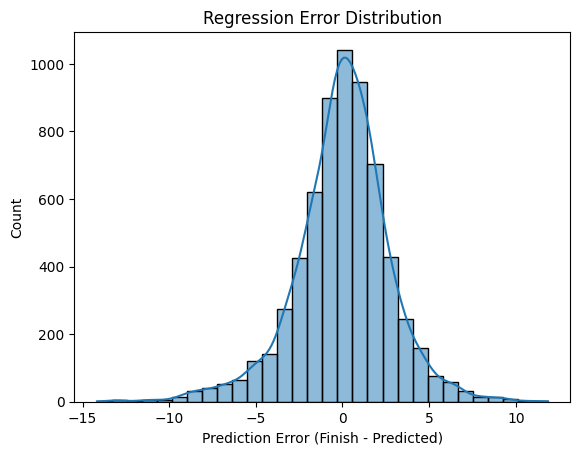

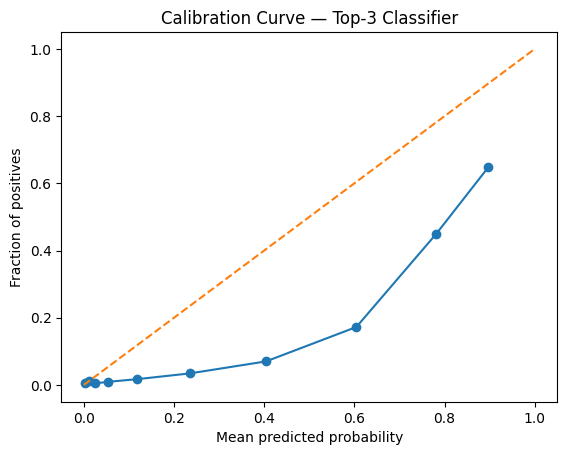

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

pipe.fit(X, y)
preds_all = pipe.predict(X)
errs = preds_all - y.values

plt.figure()
sns.histplot(errs, bins=30, kde=True)
plt.xlabel("Prediction Error (Finish - Predicted)")
plt.title("Regression Error Distribution")
plt.show()

clf.fit(Xc, yc)
prob = clf.predict_proba(Xc)[:,1]
frac_pos, mean_pred = calibration_curve(yc, prob, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve — Top-3 Classifier")
plt.show()


In [9]:

import joblib, os
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe, "artifacts/finish_regressor_xgb.pkl")
joblib.dump(clf, "artifacts/top3_classifier_lr.pkl")
print("Saved to artifacts/")


Saved to artifacts/
